In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

In [ ]:
merged_df = pd.read_csv('data/filtered/merged_valais.csv')


In [ ]:
cleandf = pd.read_csv('data/clean/valais_clean.csv')
staticdf = pd.read_csv('data/clean/valais_stations.csv')

In [ ]:
#Highest precipitation over 10 minutes
merged_df.sort_values('precip', ascending=False).head(10)

In [ ]:
precip_copy = merged_df.copy()

precip_copy['dry'] = (precip_copy['precip']==0).astype(int)

precip_copy['dry_group'] = precip_copy.groupby('station')['dry'].diff().ne(0).cumsum()

dry_periods = precip_copy[precip_copy['dry'] == 1].groupby(['station', 'dry_group'])['time'].agg(['min', 'max', 'count']).reset_index()

output = dry_periods.sort_values('count', ascending=False)

print(output.head(5).to_latex(index=False, caption="Top 5 Longest Dry Periods", label="tab:dry_periods"))

In [ ]:
#highest amount of precipitation
precip_sum = cleandf[['precip', 'station']].groupby('station').sum()
print("Station with the highest total precipitation: \n ")
print(precip_sum.sort_values('precip', ascending=False).head(1))

print("Station with the lowest total precipitation:")
print(precip_sum.sort_values('precip', ascending=False).tail(1))

#precipitation mean()
precip_sum = cleandf[['station', 'precip']].groupby('station').mean()
print("Station with the highest average precipitation:")
print(precip_sum.sort_values('precip', ascending=False).head(1))

print("Station with the lowest average precipitation:")
print(precip_sum.sort_values('precip', ascending=False).tail(1))

## Temperatures

In [ ]:
#First we must only take stations that record temps, and not those who interpolated it otherwise its bad I think
clean = cleandf[['temperature', 'station', 'time']]
temperature_fake = clean.merge(staticdf, on='station', how='left')

temperature = temperature_fake[temperature_fake['temperature_bool']==True]

In [ ]:
temperature['station'].unique()

In [ ]:
#Highest temperature recorded
temperature = cleandf[['temperature', 'station', 'time']]
temp1 = temperature[temperature['station']!='SIO']
temp1.sort_values('temperature', ascending=False).head(10)

In [ ]:
#Lowest temp
temp2 = temperature[temperature['station']!="ULR"]
temperature.sort_values('temperature', ascending=True).head(30)

Taking a look at min max and averages in days.  

In [ ]:
temps = temperature.copy()
temps['time'] = pd.to_datetime(temps['time'], format='%Y%m%d%H%M')

df_daily = (
    temps
    .groupby('station')
    .resample('D', on='time')
    .agg(
        temp_min=('temperature', 'min'),
        temp_max=('temperature', 'max'),
        temp_avg=('temperature', 'mean')
    )
    .reset_index()
)

In [ ]:
#we take the average by station, we'll get an overall average and then get the altitude
avg_overall = (df_daily[['station', 'temp_min', 'temp_max', 'temp_avg']]
               .groupby('station')
               .aggregate('mean'))
print(avg_overall.to_latex(index=True, 
                           caption="Minimum, Maximum and Mean values over the period", 
                           label="tab:avg_stations_temp",
                           float_format="{:.2f}".format))

temp average and altitude

In [ ]:
#station with the most summer days
summer_days = df_daily[df_daily['temp_max']>=25].copy()
summer_day_count = (summer_days[['station', 'temp_max']]
                    .groupby('station')
                    .count()
                    .sort_values('temp_max', ascending=False))
summer_day_count

In [ ]:
summary_counts = df_daily.groupby('station').agg(
    summer_days = ('temp_max', lambda x: (x >= 25).sum()),
    hot_days = ('temp_max', lambda x: (x >= 30).sum()),
    tropical_nights = ('temp_min', lambda x: (x >= 20).sum()),
    frost_days = ('temp_min', lambda x: (x < 0).sum()),
    ice_days = ('temp_max', lambda x: (x < 0).sum()),
    heating_days = ('temp_avg', lambda x: (x < 12).sum())
)

summary_counts = summary_counts.sort_values('tropical_nights', ascending=False)
summary_counts


In [ ]:
df_daily['tropical_night'] = df_daily['temp_min'] >= 20
df_daily['frost_day'] = df_daily['temp_min'] <= 0
df_daily['ice_day'] = df_daily['temp_max'] <= 0
df_daily['heating_day'] = df_daily['temp_avg'] <= 12

# Aggregate across stations (number of stations each day with that condition)
timeseries = df_daily.groupby('time')[['tropical_night', 'frost_day', 'ice_day', 'heating_day']].sum()

timeseries.rolling(7).mean().plot(figsize=(12,6))  # Optional smoothing with rolling mean
plt.title("Daily Count of Stations with Special Temperature Days")
plt.ylabel("Number of Stations")
plt.xlabel("Date")
plt.legend(title="Day Type")
plt.tight_layout()
plt.savefig("report/figures/timeseries_special_days.pdf")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming summary_counts exists

# Define cold and warm day types (order matters!)
cold_cols = ['heating_days', 'frost_days', 'ice_days']
warm_cols = ['summer_days', 'hot_days', 'tropical_nights']

# Extract subsets
colds = summary_counts[cold_cols]
warms = summary_counts[warm_cols]

# Normalize each subset column-wise
scaler = MinMaxScaler()
norm_colds = pd.DataFrame(scaler.fit_transform(colds), columns=cold_cols, index=colds.index)
norm_warms = pd.DataFrame(scaler.fit_transform(warms), columns=warm_cols, index=warms.index)

# Plot side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

sns.heatmap(norm_warms, annot=warms, cmap="YlOrRd", fmt='d', ax=ax1, cbar=False)
ax1.set_title("Warm-Related Days", fontsize=13)
ax1.set_xlabel("")
ax1.set_ylabel("Station", fontsize=13)

sns.heatmap(norm_colds, annot=colds, cmap="PuBu", fmt='d', ax=ax2, cbar=False)
ax2.set_title("Cold-Related Days", fontsize=12)
ax2.set_xlabel("")
ax2.tick_params(axis='y', length=0)
ax2.set_ylabel("")

plt.suptitle("Special Temperature Days", fontsize=12)
fig.text(0.525, -0.02, "Day Type", ha='center', fontsize=13)
plt.tight_layout()
plt.savefig("report/figures/special_days_heatmap.pdf", bbox_inches='tight')
plt.show()

In [ ]:
percent_df = df_daily.groupby('time')[['tropical_night', 'frost_day', 'ice_day', 'heating_day']].mean() * 100

percent_df.rolling(7).mean().plot(figsize=(12,6))
plt.ylabel("% of Stations")
plt.title("Percentage of Stations with Special Day Types")
plt.tight_layout()

In [ ]:
station_alt = staticdf[['station', 'altitude']]
alt_temp = avg_overall.merge(station_alt, on='station', how='left')
alt_temp
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=alt_temp, x='temp_avg', y='altitude')
for _, row in alt_temp.iterrows():
    ax.text(row['temp_avg'], row['altitude'], row['station'], fontsize=9, ha='right', va='bottom')
 
ax.set_xlabel("Average Temperature (°C)", fontsize=13)
ax.set_ylabel("Altitude (m)", fontsize=13)
ax.set_title("Temperature average depending on the altitude", fontsize=13)

plt.tight_layout()
plt.savefig("report/figures/avg_temp_vs_alt.pdf")
plt.show()

In [ ]:
df = alt_temp[['altitude', 'temp_avg']].copy()

df.corr()

# PRESSURE

In [157]:
prez = cleandf.copy()
prez = prez.merge(staticdf, on='station', how='left')

pressure_df = prez[prez['pression_bool']==True]
pressure_df

,time,station,precip,East,North,moisture,pressure,temperature,precip_interpolated,East_interpolated,...,east,north,altitude,Canton,precip_bool,temperature_bool,pression_bool,moisture_bool,North_bool,East_bool
262944,201901010000,BLA,0.0,1.35,0.75,76.3,1030.6,-2.6,0,0,...,629564,141084,1538,VS,True,True,True,True,True,True
262945,201901010010,BLA,0.0,0.36,0.48,79.2,1030.5,-2.4,0,0,...,629564,141084,1538,VS,True,True,True,True,True,True
262946,201901010020,BLA,0.0,0.15,0.27,79.3,1030.5,-3.0,0,0,...,629564,141084,1538,VS,True,True,True,True,True,True
262947,201901010030,BLA,0.0,0.60,0.80,79.9,1030.6,-2.7,0,0,...,629564,141084,1538,VS,True,True,True,True,True,True
262948,201901010040,BLA,0.0,1.08,0.60,76.2,1030.6,-2.1,0,0,...,629564,141084,1538,VS,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12621307,202312312310,ZER,0.0,2.45,2.45,95.0,1010.1,-2.0,0,0,...,624298,97574,1638,VS,True,True,True,True,True,True
12621308,202312312320,ZER,0.0,1.56,2.08,92.7,1010.4,-2.1,0,0,...,624298,97574,1638,VS,True,True,True,True,True,True
12621309,202312312330,ZER,0.0,1.44,1.92,94.1,1010.5,-2.0,0,0,...,624298,97574,1638,VS,True,True,True,True,True,True
12621310,202312312340,ZER,0.0,1.50,2.00,94.2,1010.5,-2.1,0,0,...,624298,97574,1638,VS,True,True,True,True,True,True


In [158]:
pressure_df[['time', 'station', 'pressure']].sort_values('pressure', ascending=False).head(5)

,time,station,pressure
4467939,202312170830,SIO,1044.9
4467800,202312160920,SIO,1044.8
4467798,202312160900,SIO,1044.8
4467801,202312160930,SIO,1044.8
4467945,202312170930,SIO,1044.8


In [ ]:
pres_list = np.array(pressure[['station', 'pressure']].groupby('station').mean())
np.average(pres_list)
np.var(pres_list)

np.float64(0.18106849929938298)

In [164]:
po = pressure_df[['time', 'station', 'pressure']].sort_values('pressure', ascending=False).groupby('station').head(1)
print(po.to_latex(index=False, 
                           caption="Minimum pressure values per station", 
                           label="tab:station_pres_min",
                           float_format="{:.1f}".format))

\begin{table}
\caption{Minimum pressure values per station}
\label{tab:station_pres_min}
\begin{tabular}{rlr}
\toprule
time & station & pressure \\
\midrule
202312170830 & SIO & 1044.9 \\
202312170710 & EVI & 1043.7 \\
202001210700 & VIS & 1041.4 \\
202312161000 & MOB & 1040.5 \\
202001202240 & ULR & 1040.2 \\
202001202320 & SIM & 1040.0 \\
202312170910 & ZER & 1039.8 \\
202312170930 & BLA & 1039.6 \\
202312170940 & MTE & 1039.4 \\
202312171900 & EVO & 1039.2 \\
202312170950 & MVE & 1039.0 \\
202312170900 & GRC & 1038.9 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
stuff = cleandf[['time', 'station', 'pressure', 'temperature', 'humidity']]

# Wind

In [165]:
winds_inter = cleandf[['time', 'station', 'East', 'North']].copy()
winds_inter = winds_inter.merge(staticdf, on='station', how='left')

wind_vec = winds_inter[winds_inter['pression_bool']==True]
wind_vec

,time,station,East,North,name,east,north,altitude,Canton,precip_bool,temperature_bool,pression_bool,moisture_bool,North_bool,East_bool
262944,201901010000,BLA,1.35,0.75,"Blatten, Lötschental",629564,141084,1538,VS,True,True,True,True,True,True
262945,201901010010,BLA,0.36,0.48,"Blatten, Lötschental",629564,141084,1538,VS,True,True,True,True,True,True
262946,201901010020,BLA,0.15,0.27,"Blatten, Lötschental",629564,141084,1538,VS,True,True,True,True,True,True
262947,201901010030,BLA,0.60,0.80,"Blatten, Lötschental",629564,141084,1538,VS,True,True,True,True,True,True
262948,201901010040,BLA,1.08,0.60,"Blatten, Lötschental",629564,141084,1538,VS,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12621307,202312312310,ZER,2.45,2.45,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True
12621308,202312312320,ZER,1.56,2.08,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True
12621309,202312312330,ZER,1.44,1.92,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True
12621310,202312312340,ZER,1.50,2.00,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True


In [166]:
wind_vec[['station', 'East', 'North']].groupby('station').mean()

,East,North
station,,
BLA,0.303668,0.120660
EVI,-0.132971,0.097121
EVO,-0.059877,0.380656
GRC,0.276963,0.579605
MOB,-0.061274,0.149472
MTE,0.028024,-0.435495
MVE,-0.005450,0.504990
SIM,-1.512108,1.465778
SIO,-0.907058,-0.447674


In [ ]:
average_vec = wind_vec[['station', 'East', 'North']].groupby('station').mean()
average_vec['theta'] = np.arctan2(average_vec['East'], average_vec['North'])
average_vec['magnitude'] = np.sqrt(average_vec['East']**2 + average_vec['North']**2)
angles = np.arange(0, 360, 45)
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

norm = mcolors.Normalize(vmin=average_vec['magnitude'].min(),
                         vmax=average_vec['magnitude'].max())
cmap = cm.Blues

# Plot in polar
fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(8, 8))

for _,row in average_vec.iterrows():
    color = cmap(row['magnitude'])
    ax.arrow(row['theta'], 0, 0, 1,
             length_includes_head=True,
             head_width=0.2,
             color=color)
    ax.text(row['theta'], 1, row.name, ha='center', va='center')
ax.set_title("Average Wind Direction and Speed per Station", fontsize=13)
ax.set_theta_zero_location('N')  # Puts 0° (North) at the top
ax.set_theta_direction(-1) 
ax.set_thetagrids(angles, labels)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label("Average Wind Speed (m/s)")

plt.tight_layout()
plt.savefig('report/figures/wind_direction.pdf')
plt.show()


In [190]:
average_vec.sort_values('magnitude', ascending=False)

,East,North,theta,magnitude
station,,,,
SIM,-1.512108,1.465778,-0.800955,2.105938
SIO,-0.907058,-0.447674,-2.029266,1.011517
VIS,-0.902767,-0.127233,-1.710811,0.911689
ULR,0.839487,0.165376,1.376291,0.855621
GRC,0.276963,0.579605,0.445769,0.642379
MVE,-0.005450,0.504990,-0.010792,0.505019
MTE,0.028024,-0.435495,3.077331,0.436396
EVO,-0.059877,0.380656,-0.156021,0.385336
ZER,0.321973,0.136429,1.170004,0.349684


In [ ]:
wind = pd.read_csv('data/processed/wind_speed.csv')


In [201]:
test = wind_vec[['time', 'station', 'East', 'North']].copy()
test['speed'] = np.sqrt(test['East']**2 + test['North']**2)





In [203]:
test.sort_values('speed', ascending=False).head()

,time,station,East,North,speed
4765064,201908111720,VIS,-20.20,6.06,21.089419
4994664,202312230400,VIS,-18.80,1.88,18.893766
847314,202002110300,EVI,7.64,17.19,18.811318
4994661,202312230330,VIS,-18.40,3.68,18.764392
847316,202002110320,EVI,9.05,16.29,18.635091


Semi-variogram

In [ ]:
rainfall = cleandf[['time', 'station', 'precip']].copy()
day_rain = rainfall[rainfall['time']==202105101340]
day_rain = day_rain.merge(staticdf, on='station', how='left')
day_rain_small = day_rain[['station', 'precip', 'east', 'north', 'altitude']].copy().reset_index()
day_rain_small


,index,station,precip,east,north,altitude
0,0,BIN,0.7,657996,135422,1479
1,1,BLA,0.0,629564,141084,1538
2,2,BRI,0.0,640567,129069,665
3,3,EVI,0.0,568197,114693,482
4,4,EVO,0.0,605412,106748,1825
5,5,FIO,0.2,589960,97765,1500
6,6,FIT,0.2,653990,142082,1175
7,7,GRC,0.0,630738,116062,1605
8,8,LEU,0.0,614083,135090,1286
9,9,MAB,0.0,570920,106546,461


c:\Users\elwin\Desktop\MeteoThesis\.venv\Lib\site-packages\gstools\covmodel\plot.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


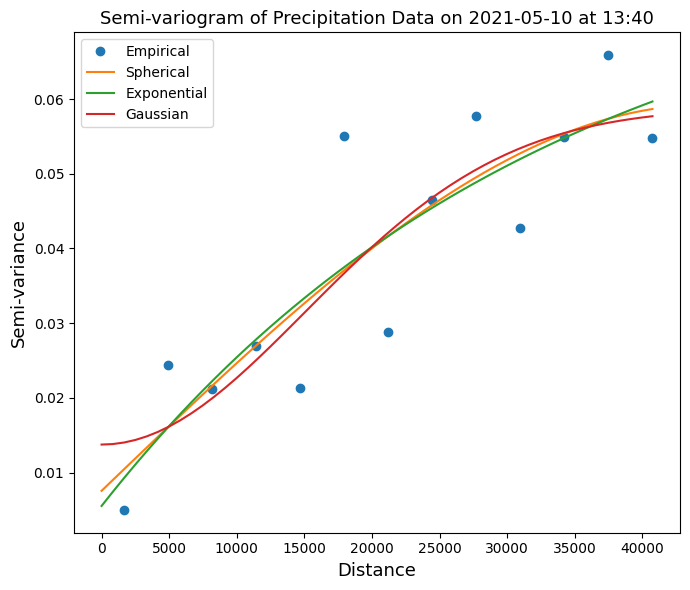

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

# Extract coordinates and values
coords = day_rain_small[['east', 'north']].values.T  # shape: (2, N)
values = day_rain_small['precip'].values
altitude = day_rain_small['altitude'].values
stations = day_rain_small['station'].values

# Set up subplots
fig, ax = plt.subplots(figsize=(7, 6))

# -------- Left: Variogram without external drift --------
ax.set_title("Semi-variogram of Precipitation Data on 2021-05-10 at 13:40", fontsize=13)

# Empirical variogram and model fitting
bin_center, gamma = gs.vario_estimate(coords, values)
model_spher = gs.Spherical(dim=2)
model_spher.fit_variogram(bin_center, gamma)

model_exp = gs.Exponential(dim=2)
model_exp.fit_variogram(bin_center, gamma)

model_gaus = gs.Gaussian(dim=2)
model_gaus.fit_variogram(bin_center, gamma)


# Plot empirical and fitted variogram
ax.plot(bin_center, gamma, 'o', label='Empirical')
model_spher.plot(x_max=np.max(bin_center), ax=ax, label='Spherical')
model_exp.plot(x_max=np.max(bin_center), ax=ax, label='Exponential')
model_gaus.plot(x_max=np.max(bin_center), ax=ax, label='Gaussian')
ax.set_xlabel("Distance", fontsize=13)
ax.set_ylabel("Semi-variance", fontsize=13)
ax.legend()

# Final layout
plt.tight_layout()
plt.savefig('report/figures/variogram_example.pdf')
plt.show()


['BIN' 'BLA' 'BRI' 'EVI' 'EVO' 'FIO' 'FIT' 'GRC' 'LEU' 'MAB' 'MAR' 'MOB'
 'MTE' 'MVE' 'ORS' 'SIM' 'SIO' 'ULR' 'VIS' 'VSANZ' 'VSARO' 'VSBRU' 'VSBSP'
 'VSCHO' 'VSCLU' 'VSCOL' 'VSDER' 'VSDUR' 'VSEMO' 'VSERG' 'VSFIN' 'VSFLY'
 'VSGDX' 'VSISE' 'VSJEI' 'VSMAT' 'VSMOI' 'VSNEN' 'VSSAB' 'VSSAL' 'VSSFE'
 'VSSIE' 'VSSOR' 'VSSTA' 'VSTUR' 'VSVER' 'VSVIS' 'ZER']


c:\Users\elwin\Desktop\MeteoThesis\.venv\Lib\site-packages\gstools\covmodel\plot.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


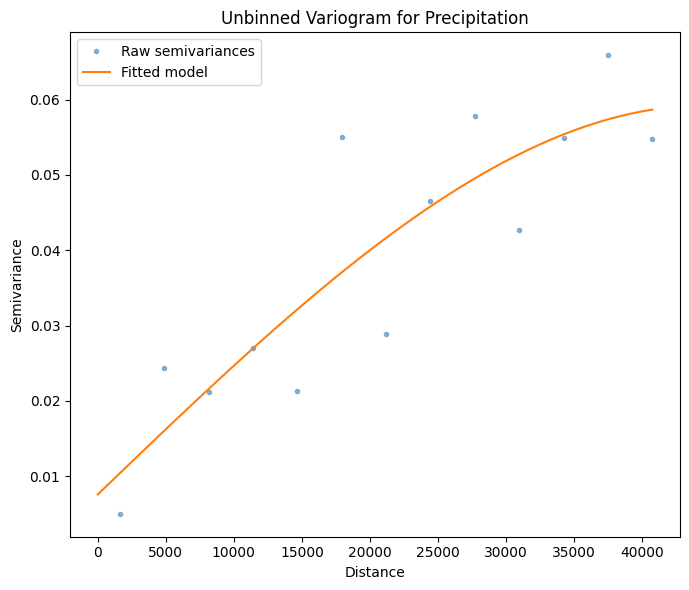

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

# Extract coordinates and values
coords = day_rain_small[['east', 'north']].values.T  # (2, N)
values = day_rain_small['precip'].values
stations = day_rain_small['station'].values
print(stations)
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_title("Unbinned Variogram for Precipitation")

# Compute *all* pairwise distances and semivariances (no bins)
distances, semivariances = gs.vario_estimate(coords, values, bin_edges=None)

# Plot raw semivariances as points
ax.plot(distances, semivariances, 'o', markersize=3, alpha=0.5, label='Raw semivariances')

# Fit model on binned variogram (to get smooth fit for visualization)
bin_center, gamma = gs.vario_estimate(coords, values)  # default binning
model = gs.Spherical(dim=2)
model.fit_variogram(bin_center, gamma)
model.plot(x_max=np.max(bin_center), ax=ax, label='Fitted model')

ax.set_xlabel("Distance")
ax.set_ylabel("Semivariance")
ax.legend()
plt.tight_layout()
plt.show()
